In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import json
from sklearn.model_selection import GroupKFold
import albumentations as A

/home/dmitriishubin/anaconda3/envs/thesis/lib/python3.7/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


# Format Data

In [2]:
def permute(image):
    image = torch.Tensor(image)
    image = image.permute(3,0,1,2).numpy()
    return image

In [3]:
DATA_PATH = '../data/brats_dataset/raw_data/'
OUT_PATH = '../data/brats_dataset/processed_data_2d/'
TABLE_PATH = '../data/split_tables/brats_2d/'
os.makedirs(TABLE_PATH,exist_ok=True)

In [4]:
patient_list = [i for i in os.listdir(DATA_PATH) if i.find('g_')!=-1]
n_slices_width = 128

In [6]:
for patient in tqdm(patient_list):
    img_flair = np.array(nib.load(DATA_PATH+patient+'/'+patient+'_flair.nii.gz').dataobj)
    img_t1 = np.array(nib.load(DATA_PATH+patient+'/'+patient+'_t1.nii.gz').dataobj)
    img_t1ce = np.array(nib.load(DATA_PATH+patient+'/'+patient+'_t1ce.nii.gz').dataobj)
    img_t2 = np.array(nib.load(DATA_PATH+patient+'/'+patient+'_t2.nii.gz').dataobj)
    seg = np.array(nib.load(DATA_PATH+patient+'/'+patient+'_seg.nii.gz').dataobj)
    
    img = np.stack([img_flair,img_t1,img_t1ce,img_t2],axis=0)
    
    seg = seg.reshape(1,seg.shape[0],seg.shape[1],seg.shape[2])
    seg[seg==4] = 3

    os.makedirs(OUT_PATH+patient,exist_ok=True)
    
 
    
    for i in range(img.shape[-1]):
        temp = img[:,:,:,i]
        temp_y = seg[:,:,:,i]

        
        #save
        np.save(OUT_PATH+patient+f'/{i}_voxels.npy',temp)
        np.save(OUT_PATH+patient+f'/{i}_labels.npy',temp_y)
    


100%|██████████| 369/369 [07:12<00:00,  1.17s/it]


# Prepare split tables

In [13]:
patient_list = [OUT_PATH[1:]+i for i in os.listdir(OUT_PATH) if i.find('.')==-1]
print(f'Total number of patients: {len(patient_list)}')

Total number of patients: 369


In [14]:
patient_arr = []
records = []
for patient in patient_list:
    records += [patient+'/'+i for i in os.listdir('.'+patient) if i.find('voxels')!=-1]
    patient_arr += [patient]*len([patient+'/'+i for i in os.listdir('.'+patient) if i.find('voxels')!=-1])
    
records = np.array(records)
patient_arr = np.array(patient_arr)

In [15]:
#create test
kf = GroupKFold(n_splits=2)

for (train,test) in kf.split(records,records,patient_arr):
    
    records_test = records[test]
    
    
    #create test
    split = {
            'test': records_test.tolist(),
        }
    
    with open(f'{TABLE_PATH}test_split_table.json', 'w') as outfile:
            json.dump(split, outfile)
    break

patient_arr = patient_arr[train]
records = records[train]

In [16]:
#create train and validation
kf = GroupKFold(n_splits=2)

for (train,test) in kf.split(records,records,patient_arr):
    
    records_test = records[test]
    
    
    #create test
    split = {
            'test': records_test.tolist(),
        }
    
    with open(f'{TABLE_PATH}test_split_table.json', 'w') as outfile:
            json.dump(split, outfile)
    break

patient_arr = patient_arr[train]
records = records[train]

In [17]:
#create train and validation
n_patients = [2,4,8]

patients_unique = np.unique(patient_arr)

for i in n_patients:
    
    train_patients = patients_unique[:i]
    train_records = np.empty(0)
    for patient in train_patients.tolist():
        train_records = np.append(train_records,records[patient_arr==patient],axis=0)
    
    val_patients = patients_unique[-2:]
    val_records = np.empty(0)
    for patient in val_patients.tolist():
        val_records = np.append(val_records,records[patient_arr==patient],axis=0)
    
    
    
    split = {
            'train': train_records.tolist(),
            'val': val_records.tolist(),
            'pretrain': records.tolist(),
        }
    with open(f'{TABLE_PATH}{i}_split_table.json', 'w') as outfile:
            json.dump(split, outfile)


In [18]:
#create UB

train_patients = patients_unique[:patients_unique.shape[0]//2]
train_records = np.empty(0)
for patient in train_patients.tolist():
    train_records = np.append(train_records,records[patient_arr==patient],axis=0)

val_patients = patients_unique[patients_unique.shape[0]//2:]
val_records = np.empty(0)
for patient in val_patients.tolist():
    val_records = np.append(val_records,records[patient_arr==patient],axis=0)

split = {
        'train': train_records.tolist(),
        'val': val_records.tolist(),
        }
with open(f'{TABLE_PATH}UB_split_table.json', 'w') as outfile:
            json.dump(split, outfile)


# Review augs

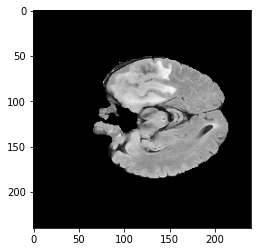

In [21]:
prob = 100
augs = A.Compose(
                [   
                    #A.HorizontalFlip(p=prob),
                    #A.VerticalFlip(p=prob),
                    #A.Rotate(limit=10, p=prob),
                    A.RandomSizedCrop(min_max_height=(90, 90), height=210, width=210, p=prob),
                    #A.ElasticTransform(alpha=0.05,sigma=12,alpha_affine=12,p=prob)
                ])
temp = np.transpose(temp.astype(np.float32), (1, 2, 0))
augmented = augs(image=temp)
temp = np.transpose(temp.astype(np.float32), (2, 0, 1))
image = augmented['image']
image = np.transpose(image.astype(np.float32), (2, 0, 1))

plt.imshow(temp[0],'gray')

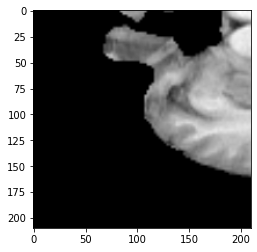

In [22]:
plt.imshow(image[1],'gray')

In [23]:
import numpy as np
import cv2

def rotate_image(image, angle):
    image = np.transpose(image.astype(np.float32), (1, 2, 0))
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    result = np.transpose(result.astype(np.float32), (2, 0, 1))
    return result

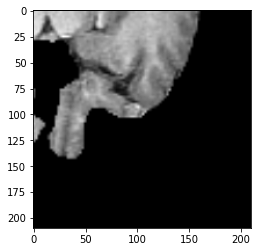

In [24]:
y = rotate_image(image,90)
plt.imshow(y[2],'gray')